In [1]:
import numpy as np
from pyedflib import highlevel
import matplotlib.pyplot as plt

## EEG Signals

- 64 Channels described on `signal_headers` (sample rate, dimension and DAC gain.)
- 109 volunteers
- 1500 One and two minute recordings.

In [2]:
sample_rate = 160.0

In [3]:
def read_edf_file(path: str):
    signals, signal_headers, header = highlevel.read_edf(path)
    annotations = header["annotations"]
    channels_labels = [i["label"] for i in signal_headers]
    return signals, annotations, channels_labels

def plot_time_signal(t: np.ndarray, signal: np.ndarray, channel: str) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    ax.plot(t, signal)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(channel)
    ax.grid(True)
    
def get_time_vector(signal: np.ndarray):
    t = np.arange(0, len(signal) / 160.0, (1 / 160.0))
    return t

def file_names_generator(subject_number: int):
    tasks_number = 14
    file_names = [f"S{subject_number:03}R{i:02}.edf" for i in range(1, tasks_number + 1)]
    return file_names
    

In [10]:
subject_number = 1
file_names = file_names_generator(subject_number)

In [19]:
channel_index = 0
file_index = 2
signals, annotations, channels_labels = read_edf_file(f"../data/{file_names[file_index]}")
t = get_time_vector(signals[channel_index])
y = signals[channel_index, :]

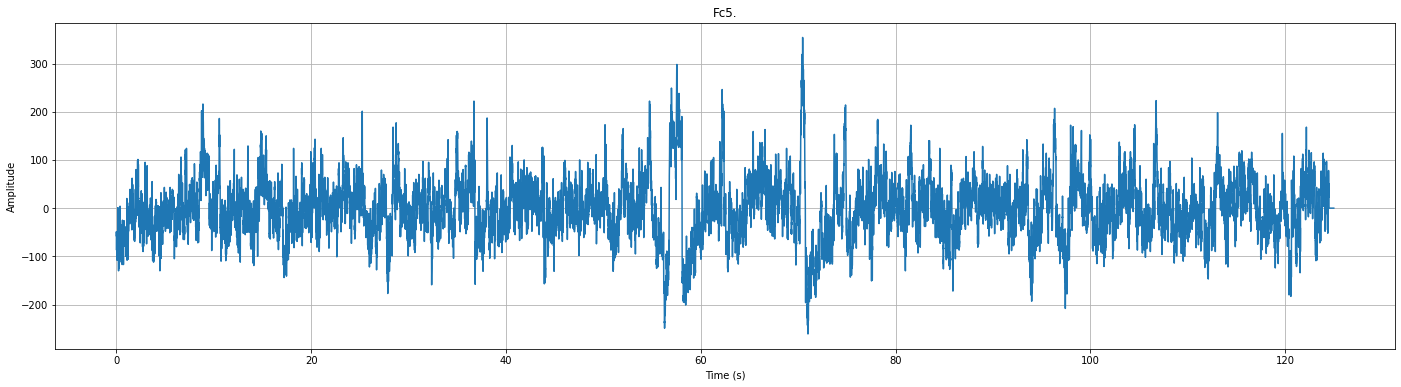

In [20]:
plot_time_signal(t, y, channels_labels[channel_index])

## TODO
- Init a repo and push to github
- Start adding precommit hooks
    - Linter
    - Formatter
    - JSON
    - YAML
- Define the task
    - Want to detect where is the beggining and end?
    - Want to classify a segment as certain task? or the whole signal?
- Choose a subset of subjects (could be 20)
- Reduce the number of channels using dimensionality reduction methods
    - PCA
- Segment signals in different tasks according to annotations
- Develop various feature extraction pipelines
    - In time domain
    - In frequency domain
    - Extract spectrogram and image based features
- Review dataset balance after segmentation
- Check which models are better to identify the parts of interest
    - Convolutional neural network
    - LSTM neural network
    - XGBoost classifier